# Linear Regressing Player Data
### Version 2: 15/10/2023

Using the data from @vaastav (big shout out) - linear regressing the points achieved in a game by a player, based on a selection of inputs that I should have available beforehand. I've got a strong hypothesis on the game outcome!

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd 
import fnmatch
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
years = []
for i in range(0,4):
    j = str(i)
    k = str(i+1)
    years.append("202"+j+"-2"+k)
    print(years)

['2020-21']
['2020-21', '2021-22']
['2020-21', '2021-22', '2022-23']
['2020-21', '2021-22', '2022-23', '2023-24']


In [3]:
all_years = pd.DataFrame()
for year in years:
    url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{}/gws/merged_gw.csv".format(year)
    df = pd.read_csv(url)
    df['season'] = int(year[:4])
    all_years = pd.concat([all_years, df]).fillna('')

In [4]:
all_years.dtypes

name                           object
position                       object
team                           object
xP                            float64
assists                         int64
bonus                           int64
bps                             int64
clean_sheets                    int64
creativity                    float64
element                         int64
fixture                         int64
goals_conceded                  int64
goals_scored                    int64
ict_index                     float64
influence                     float64
kickoff_time                   object
minutes                         int64
opponent_team                   int64
own_goals                       int64
penalties_missed                int64
penalties_saved                 int64
red_cards                       int64
round                           int64
saves                           int64
selected                        int64
team_a_score                    int64
team_h_score

In [5]:
all_years.describe()

,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW,season
count,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,81922.000000,...,81922.000000,81922.000000,81922.000000,8.192200e+04,8.192200e+04,8.192200e+04,81922.000000,81922.000000,81922.000000,81922.000000
mean,1.300120,0.036315,0.095750,5.371268,0.093089,4.199993,338.848173,188.304070,0.459083,0.040148,...,1.501257,4.612143,1.233381,1.754245e+03,1.548643e+04,1.373175e+04,50.358182,0.050438,19.814592,2021.162960
std,2.154451,0.203333,0.463338,9.307156,0.290558,10.068143,198.254050,112.457656,0.948982,0.218719,...,1.350946,12.329733,2.419281,7.244426e+04,6.295421e+04,5.326949e+04,11.882094,0.218849,11.309848,0.931711
min,-3.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-7.000000,-2.180978e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000,2020.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,84.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,-1.238000e+03,3.800000e+01,1.120000e+02,44.000000,0.000000,9.000000,2020.000000
50%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,336.000000,190.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,-5.700000e+01,3.670000e+02,9.530000e+02,47.000000,0.000000,21.000000,2021.000000
75%,2.000000,0.000000,0.000000,9.000000,0.000000,1.600000,504.000000,287.000000,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.900000e+01,4.419000e+03,7.019000e+03,54.000000,0.000000,29.000000,2022.000000
max,23.600000,4.000000,3.000000,128.000000,1.000000,136.200000,778.000000,380.000000,9.000000,4.000000,...,9.000000,169.000000,24.000000,1.983733e+06,2.104464e+06,2.233619e+06,141.000000,1.000000,38.000000,2023.000000


## Feature Engineering

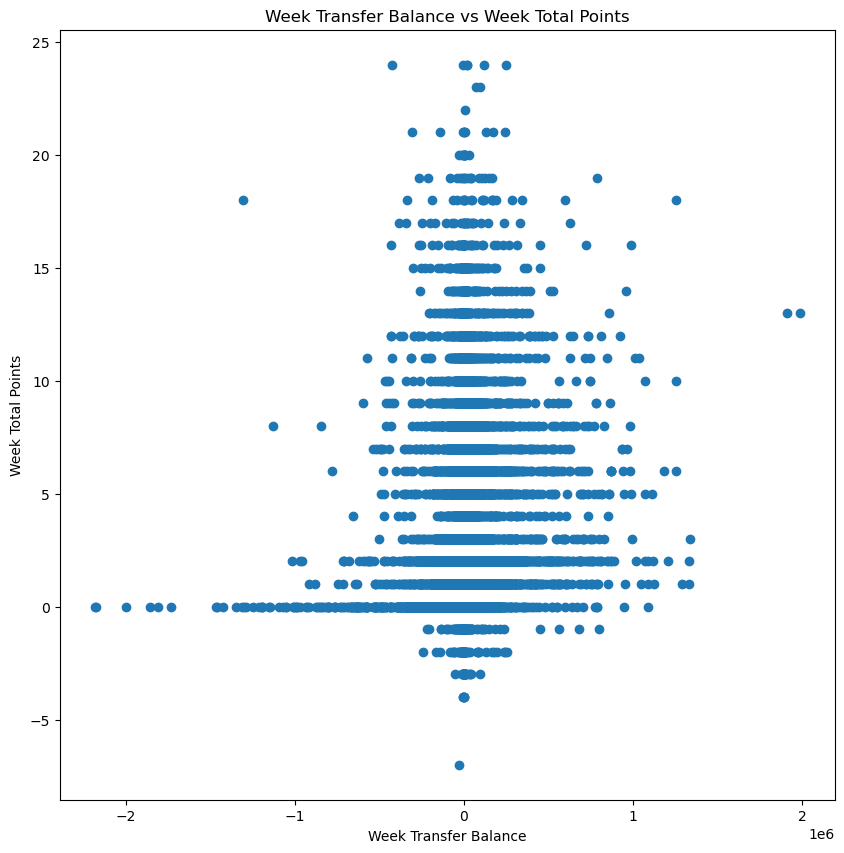

In [6]:
# Checking the correlation of transfer balance and points #
plt.figure(figsize=(10,10))
plt.scatter(all_years['transfers_balance'],all_years['total_points'])
plt.title('Week Transfer Balance vs Week Total Points')
plt.xlabel('Week Transfer Balance')
plt.ylabel('Week Total Points')
plt.show()

<Axes: xlabel='total_points'>

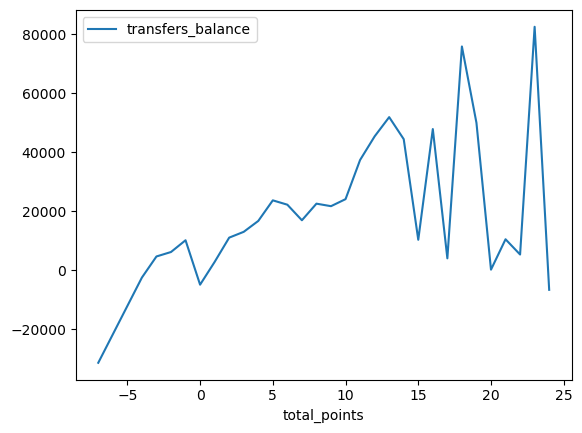

In [7]:
mean_transfers_balance = all_years.groupby(by=["total_points"]).mean(["transfers_balance"])
mean_transfers_balance.plot(y='transfers_balance', use_index=True)

In [8]:
all_years = all_years.sort_values(by=['name', 'season', 'GW'])
all_years.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,value,was_home,yellow_cards,GW,season,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,55,True,0,1,2020,,,,,
425,Aaron Connolly,FWD,Brighton,4.0,0,2,27,1,11.3,78,...,55,False,0,2,2020,,,,,
964,Aaron Connolly,FWD,Brighton,2.7,0,0,2,0,12.1,78,...,55,True,0,3,2020,,,,,
1518,Aaron Connolly,FWD,Brighton,2.7,0,0,7,0,0.3,78,...,55,False,0,4,2020,,,,,
2080,Aaron Connolly,FWD,Brighton,3.0,1,0,13,0,10.3,78,...,55,False,0,5,2020,,,,,


In [33]:
# Sort the values
ay_sort = all_years.sort_values(by=['name', 'season', 'GW'])
ay_sort = ay_sort[~ay_sort.index.duplicated(keep='first')]

In [10]:
# Define the columns to group by
group_columns = ['name', 'position', 'team']

# Create a custom rolling sum function
def rolling_sum(series, window_size):
    return series.rolling(window=window_size, min_periods=1).sum()

def custom_rolling(y, rolling_column_name, column_name, group_columns):
    for window_size in range(2, y):
        rolling_column = rolling_column_name + "_" + str(window_size-1)
        ay_sort[rolling_column] = ay_sort.groupby(group_columns)[column_name].transform(lambda x: rolling_sum(x, window_size)) - ay_sort[column_name]

In [11]:
def create_win_column(row):
    if row['was_home'] == True and row['team_h_score'] >  row['team_a_score']:
        return True
    elif row['was_home'] == False and  row['team_a_score'] > row['team_h_score']:
        return True
    else:
        return False

# Create the win column
ay_sort['win'] = ay_sort.apply(create_win_column, axis=1)

def create_draw_column(row):
    if row['team_h_score'] == row['team_a_score']:
        return True
    else:
        return False

# Create the draw column
ay_sort['draw'] = ay_sort.apply(create_draw_column, axis=1)

In [32]:
# rolling sum of total points up to the 10 weeks prior
custom_rolling(12, "rolling_total_points", "total_points" , group_columns)

# rolling sum of transfer balance up to the 10 weeks prior
custom_rolling(12, "rolling_transfers_balance", "transfers_balance" , group_columns)

# rolling sum of bonus pts up to the 10 weeks prior
custom_rolling(12, "rolling_bonus_points", "bonus" , group_columns)

# rolling sum of mins up to the 10 weeks prior
custom_rolling(12, "rolling_minutes", "minutes" , group_columns)

# rolling sum of wins up to the 10 weeks prior
custom_rolling(12, "rolling_wins", "win" , group_columns)

## Predicting Scores

In [13]:
pd.options.display.max_rows = 110
ay_sort.dtypes

name                             object
position                         object
team                             object
xP                              float64
assists                           int64
bonus                             int64
bps                               int64
clean_sheets                      int64
creativity                      float64
element                           int64
fixture                           int64
goals_conceded                    int64
goals_scored                      int64
ict_index                       float64
influence                       float64
kickoff_time                     object
minutes                           int64
opponent_team                     int64
own_goals                         int64
penalties_missed                  int64
penalties_saved                   int64
red_cards                         int64
round                             int64
saves                             int64
selected                          int64


In [14]:
ay_sort.dropna()

ay_sort['win'] = ay_sort['win'].astype(int)
ay_sort['draw'] = ay_sort['draw'].astype(int)

In [31]:
column_names = list(ay_sort.columns.values)

pattern = 'rolling_*5'
independent_var = fnmatch.filter(column_names, pattern)

extra_values = ['win', 'draw']
independent_var = independent_var + extra_values
print(independent_var)

['rolling_total_points_5', 'rolling_transfers_balance_5', 'rolling_bonus_points_5', 'rolling_minutes_5', 'rolling_wins_5', 'rolling_draws_5', 'win', 'draw']


In [29]:
# split into train and test split
X = ay_sort[independent_var]
y = ay_sort['total_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Stepwise feature selection
def stepwise_selection(X, y):
    selected_features = list(X.columns)
    current_best_aic = float("inf")

    while True:
        changed = False
        for feature in selected_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features].drop(columns=feature))).fit()
            aic = model.aic

            if aic < current_best_aic:
                current_best_aic = aic
                removed_feature = feature
                changed = True

        if not changed:
            break

        selected_features.remove(removed_feature)

    return selected_features

selected_features = stepwise_selection(X_train, y_train)

# Build the final model with selected features
final_model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     955.0
Date:                Sun, 22 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:32:14   Log-Likelihood:                -45596.
No. Observations:               21204   AIC:                         9.121e+04
Df Residuals:                   21196   BIC:                         9.127e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [26]:
# Build the final model with selected features for both training and testing data
final_model_test = sm.OLS(y_test, sm.add_constant(X_test[selected_features])).fit()

# Print model summaries
print("Testing Model Summary:")
print(final_model_test.summary())

Testing Model Summary:
                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     244.6
Date:                Sun, 22 Oct 2023   Prob (F-statistic):          2.37e-316
Time:                        20:32:02   Log-Likelihood:                -11510.
No. Observations:                5301   AIC:                         2.304e+04
Df Residuals:                    5293   BIC:                         2.309e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const